# Toy Models of Superposition

This notebook includes the toy model training framework used to generate most of the results in the "Toy Models of Superposition" paper.

The main useful improvement over a basic PyTorch tiny autoencoder is the ability to batch train many models with varying sparsity at once, which is much more efficient than training them one at a time.

This notebook is designed to run in Google Colab's Python 3.7 environment.

In [1]:
#!pip install einops

In [2]:
import torch
from torch import nn
from torch.nn import functional as F

from typing import Optional

from dataclasses import dataclass, replace
import numpy as np
import einops

from tqdm.notebook import trange

import time
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

In [3]:
@dataclass
class Config:
  n_features: int
  n_hidden: int
  head_d: int

  # We optimize n_instances models in a single training loop
  # to let us sweep over sparsity or importance curves 
  # efficiently.

  # We could potentially use torch.vmap instead.
  n_instances: int
 
class Model(nn.Module):
  def __init__(self, 
               config, 
               feature_probability: Optional[torch.Tensor] = None,
               importance: Optional[torch.Tensor] = None,               
               device='cuda'):
    super().__init__()
    self.config = config
    self.W = nn.Parameter(torch.empty((config.n_instances, config.n_features, config.n_hidden), device=device))
    nn.init.xavier_normal_(self.W)
    self.b_final = nn.Parameter(torch.zeros((config.n_instances, config.n_features), device=device))
    self.A = nn.Parameter(torch.empty((config.n_instances, config.n_hidden, config.head_d), device=device))
    nn.init.xavier_normal_(self.A)
    self.B = nn.Parameter(torch.empty((config.n_instances, config.n_hidden, config.head_d), device=device))
    nn.init.xavier_normal_(self.B)

    if feature_probability is None:
      feature_probability = torch.ones(())
    self.feature_probability = feature_probability.to(device)
    if importance is None:
      importance = torch.ones(())
    self.importance = importance.to(device)

  def forward(self, features):
    # features: [..., instance, n_features]
    # W: [instance, n_features, n_hidden]
    hidden = torch.einsum("...if,ifh->...ih", features, self.W)
    out = torch.einsum("...ih,ifh->...if", hidden, self.W)
    out = out + self.b_final
    out = F.relu(out)
    return out

  def generate_batch(self, n_batch):
    feat = torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device)
    batch = torch.where(
        torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device) <= self.feature_probability,
        feat,
        torch.zeros((), device=self.W.device),
    )
    return batch

# Model Architecture Diagram

This model is a **Sparse Autoencoder with Attention Mechanisms** that processes multiple instances simultaneously.

## Architecture Overview:

```
Input Features [batch, n_instances, n_features]
         ↓
    Feature Selection (sparsity via feature_probability)
         ↓
    Linear Layer W [n_instances, n_features, n_hidden]
         ↓
    Hidden Representations [batch, n_instances, n_hidden]
         ↓
    Linear Layer W^T (reconstruction)
         ↓
    Add Bias b_final
         ↓
    ReLU Activation
         ↓
Output [batch, n_instances, n_features]
```

## Attention Mechanism (for pairwise loss):
- **Query**: x @ W @ A → [batch, n_instances, head_d]
- **Key**: y @ W @ B → [batch, n_instances, head_d]  
- **Attention**: Query @ Key^T → [batch, n_instances, n_instances]
- **Diagonal**: Extract self-attention scores

## Key Components:
- **W**: Main weight matrix [n_instances, n_features, n_hidden]
- **A, B**: Attention projection matrices [n_instances, n_hidden, head_d]
- **b_final**: Output bias [n_instances, n_features]
- **feature_probability**: Controls sparsity per instance
- **importance**: Feature importance weights


In [4]:
if torch.cuda.is_available():
  DEVICE = 'cuda'
elif torch.backends.mps.is_available():
  DEVICE = "mps"
else:
  DEVICE = 'cpu'

In [5]:
def linear_lr(step, steps):
  return (1 - (step / steps))

def constant_lr(*_):
  return 1.0

def cosine_decay_lr(step, steps):
  return np.cos(0.5 * np.pi * step / (steps - 1))

'''
def feature_association(f):
  target = torch.zeros((f, f), device=DEVICE)
  target[1, 2] = 1.0
  target[3, 4] = 3.0
  return target
'''

def pair_err(A, B, W, x, y):
  """
  Pairwise error over aligned batch pairs using feature_association.
  x, y: tensors shaped [b, i, f]
  Returns a tensor broadcastable to [b, i, f] for reduction.
  """
  # Compute the outer product of the last dimensions of x and y, resulting in shape [b, i, f, f]
  # x: [b, i, f], y: [b, i, f]
  outer = x.unsqueeze(-1) * y.unsqueeze(-2)  # [b, i, f, f]
  target = feature_association(x.shape[-1])  # [f, f]
  matches = outer * target  # [b, i, f, f]
  target = matches.sum(dim=(-2, -1)) # [b, i]
  yWB = torch.einsum('bif, ifg, igh -> bih', y, W, B)
  xWA = torch.einsum('bif, ifg, igh -> bih', x, W, A)
  xWABWy = torch.matmul(xWA, yWB.transpose(-2, -1))  # [b, i, i]
  attn_pred = torch.diagonal(xWABWy, dim1=-2, dim2=-1)  # shape [b, i]
  # still need softmax here
  # Return the L2 norm of the difference between target and assoc
  return (target - attn_pred)**2

def optimize(model, 
             render=False, 
             n_batch=1024,
             steps=10_000,
             print_freq=100,
             lr=1e-3,
             lr_scale=constant_lr,
             lam = 10,
             hooks=[]):
  cfg = model.config

  opt = torch.optim.AdamW(list(model.parameters()), lr=lr)

  start = time.time()
  with trange(steps) as t:
    for step in t:
      step_lr = lr * lr_scale(step, steps)
      for group in opt.param_groups:
        group['lr'] = step_lr
      opt.zero_grad(set_to_none=True)
      batch = model.generate_batch(n_batch)
      out = model(batch)
      # Reconstruction loss (original)
      error = (model.importance*(batch.abs() - out)**2)
      recon_loss = einops.reduce(error, 'b i f -> i', 'mean').sum()
      # print('recon loss', recon_loss, recon_loss.shape)

      # Pairwise loss over batch pairs
      pairable = (n_batch // 2) * 2
      if pairable >= 2:
        # stepping by 2s in the batch dimension
        # was out
        out_a = batch[:pairable:2]
        out_b = batch[1:pairable:2]
        pair_error = pair_err(model.A, model.B, model.W, out_a, out_b)
        pair_loss = einops.reduce(pair_error, 'b i -> i', 'mean').sum()
        # print('pair_loss', pair_loss, pair_loss.shape)
      else:
        pair_error = torch.zeros_like(out[:0])
        pair_loss = torch.tensor(0.0, device=out.device)

      loss = recon_loss + lam * pair_loss
      loss.backward()
      opt.step()
    
      if hooks:
        hook_data = dict(model=model,
                         step=step, 
                         opt=opt,
                         error=error,
                         recon_loss=recon_loss,
                         pair_error=pair_error,
                         pair_loss=pair_loss,
                         loss=loss,
                         lr=step_lr)
        for h in hooks:
          h(hook_data)
      if step % print_freq == 0 or (step + 1 == steps):
        t.set_postfix(
            loss=loss.item() / cfg.n_instances,
            lr=step_lr,
        )

In [6]:
res_array = 0
def capture_stats(stats):
    global res_array
    if (stats['step']) == 0:
        res_array = []
    if (stats['step'] % 10) == 0:
        res_array.append((stats['step'], stats['recon_loss'].cpu().detach().numpy(), stats['pair_loss'].cpu().detach().numpy()))

## Basic Test

Basic setting is 30 x 15 x 10 x 10, lam = .5

In [25]:
config = Config(
    n_features = 30,
    n_hidden = 15,
    head_d = 10,
    n_instances = 7,
)
torch.manual_seed(42)
np.random.seed(42)
#random.seed(42)

model = Model(
    config=config,
    device=DEVICE,
    # Exponential feature importance curve from 1 to 1/100
    importance = (0.9**torch.arange(config.n_features))[None, :],
    # Sweep feature frequency across the instances from 1 (fully dense) to 1/20
    feature_probability = (50 ** -torch.linspace(0, 1, config.n_instances))[:, None]
)

In [26]:
def feature_association(f):
  target = torch.zeros((f, f), device=DEVICE)
  target[2, 4] = 1.0
  target[5, 8] = 2.0
  return target

lam = .5
optimize(model, lam = lam, hooks = [capture_stats])

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0, 0.5, 'pair loss')

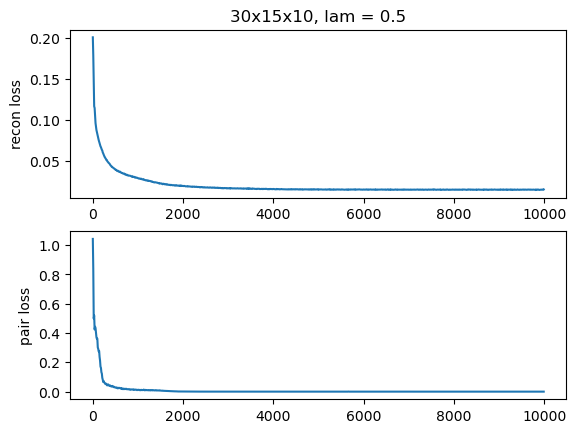

In [27]:
res = np.array(res_array)
figs, axs = plt.subplots(2, 1)
axs[0].plot(res[:,0], res[:,1])
axs[0].set_ylabel('recon loss')
axs[0].set_title(f'{config.n_features}x{config.n_hidden}x{config.head_d}, lam = {lam}')
axs[1].plot(res[:,0], res[:,2])
axs[1].set_ylabel('pair loss')

In [16]:
def render_features(model, fig_width, fig_height, which=np.s_[:]):
  cfg = model.config
  W = model.W.detach()
  W_norm = W / (1e-5 + torch.linalg.norm(W, 2, dim=-1, keepdim=True))

  interference = torch.einsum('ifh,igh->ifg', W_norm, W)
  interference[:, torch.arange(cfg.n_features), torch.arange(cfg.n_features)] = 0

  polysemanticity = torch.linalg.norm(interference, dim=-1).cpu().numpy()
  net_interference = (interference**2 * model.feature_probability[:, None, :]).sum(-1).cpu()
  norms = torch.linalg.norm(W, 2, dim=-1).cpu()

  WtW = torch.einsum('sih,soh->sio', W, W).cpu().numpy()

  # width = weights[0].cpu()
  # x = torch.cumsum(width+0.1, 0) - width[0]
  x = torch.arange(cfg.n_features)
  width = 0.9

  which_instances = np.arange(cfg.n_instances)[which]
  fig = make_subplots(
      cols=len(which_instances),
      rows=3,
      shared_xaxes=True,
      row_heights=[0.65, 1, 0.15], 
      vertical_spacing=0.0,
      horizontal_spacing=0.02  # Remove all empty space between columns
  )
  for (col, inst) in enumerate(which_instances):
    fig.add_trace(
        go.Bar(x=x.numpy(), 
              y=norms[inst].numpy(),
              marker=dict(
                  color=polysemanticity[inst],
                  cmin=0,
                  cmax=1
              ),
              width=width,
        ),
        row=1, col=1+col
    )
    # Add y-label "foo" rotated 90 degrees to the left subplot
    fig.add_annotation(
        text=f'{model.feature_probability[inst].item():.2f}',
        xref="paper", yref="paper",
        x=(len(norms[inst].numpy())-1)/2, y=-2,
        xanchor="center", yanchor="middle",
        showarrow=False,
        font=dict(size=16),
        row=3, col=1+col,
        bgcolor='rgba(0,0,0,0)'  # transparent background
    )
    data = WtW[inst]
    fig.add_trace(
        go.Image(
            z=plt.cm.coolwarm((1 + data)/2, bytes=True),
            colormodel='rgba256',
            customdata=data,
            #In: %{x}<br>
            #Out: %{y}<br>
            #Weight: %{customdata}
            hovertemplate='''\
foo
'''            
        ),
        col=1+col, row=2
    )

  fig.add_vline(
    x=(x.numpy()[cfg.n_hidden-1]+x.numpy()[cfg.n_hidden])/2, 
    line=dict(width=0.2),
    row=1,
  )
    
  # fig.update_traces(marker_size=1)
  fig.update_layout(showlegend=False, 
                    height=fig_height,
                    width=fig_width,
                    margin=dict(t=4, b=4, l=8, r=8))
  fig.update_xaxes(visible=False)
  fig.update_yaxes(visible=False)
  return fig

In [28]:
#fig = render_features(model, np.s_[::2]) # every other instance  
which = np.s_[:]
which_instances = np.arange(model.config.n_instances)[which]
fig_height = 275
fig_width = 150*len(which_instances) 
fig = render_features(model, fig_width, fig_height, which_instances)
fig.update_layout()

In [29]:
target = feature_association(model.config.n_features).detach().cpu().numpy()
nfeat = np.sum(target)
fname = f'bar-ortho-{model.config.n_features}x{model.config.n_hidden}x{model.config.head_d}-lam-{lam}-nfeat-{nfeat}.pdf'
fig.update_layout(margin=dict(t=4, b=20, l=8, r=8))
fig.write_image(fname, format='pdf', width=fig_width, height=fig_height) #doesnt work due to use of torch to create figure; can't debug
#import plotly.io as pio
##rom ironpdf import *
#pio.write_html(fig, "demo.html")
# Use IronPDF to render the HTML file as a PDF
#iron_pdf = ChromePdfRenderer()
#pdf = iron_pdf.RenderHtmlFileAsPdf("demo.html")
#pdf.SaveAs("output_from_html.pdf")



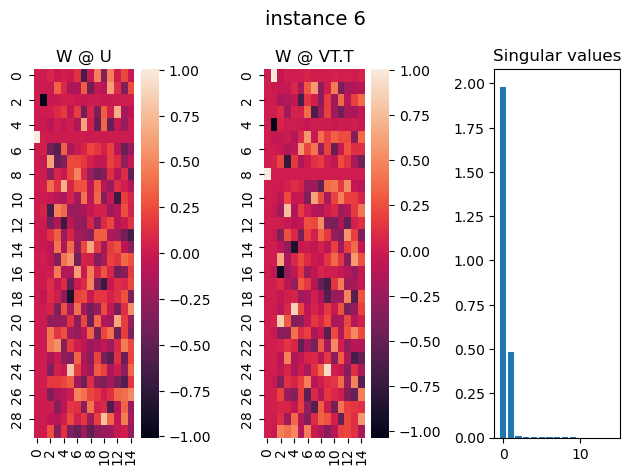

In [31]:
instance = 6
A_all = model.A.detach().cpu()
B_all = model.B.detach().cpu()
A = A_all[instance]
B = B_all[instance]
Omega = A @ B.T
U, S, VT = np.linalg.svd(Omega)
W_all = model.W.detach().cpu()
W = W_all[instance]
import seaborn as sns
figs, axs = plt.subplots(1, 3)
sns.heatmap(W @ U, ax = axs[0])
sns.heatmap(W @ VT.T, ax = axs[1])
axs[2].bar(range(len(S)), S)
axs[1].set_title(f'instance {instance}')
axs[0].set_title('W @ U')
axs[1].set_title('W @ VT.T')
axs[2].set_title('Singular values')
plt.suptitle(f'instance {instance}', fontsize=14, y=0.98)
plt.tight_layout()



ValueError: 'vertices' must be 2D with shape (N, 2), but your input has shape (2, 10)

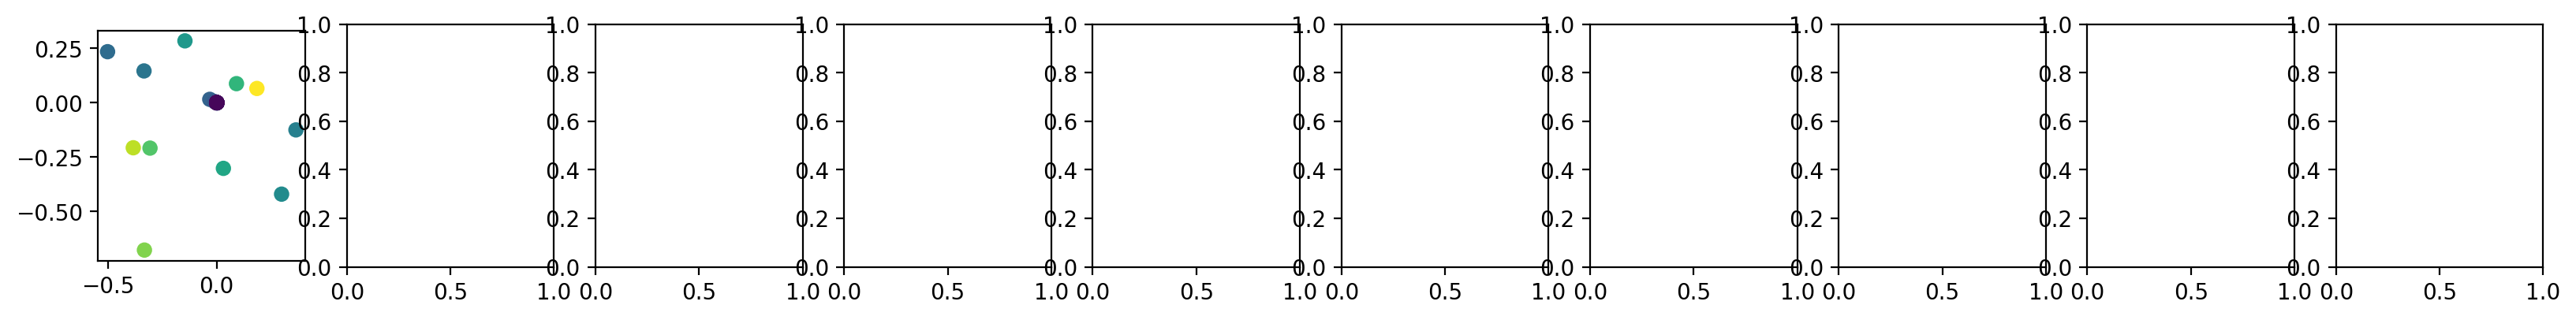

In [69]:
def plot_intro_diagram(model):
  from matplotlib import colors  as mcolors
  from matplotlib import collections  as mc
  cfg = model.config
  WA = model.W.detach()
  N = len(WA[:,0])
  sel = range(config.n_instances) # can be used to highlight specific sparsity levels
  plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(model.importance[0].cpu().numpy()))
  plt.rcParams['figure.dpi'] = 200
  fig, axs = plt.subplots(1,len(sel), figsize=(2*len(sel),2))
  for i, ax in zip(sel, axs):
      W = WA[i].cpu().detach().numpy()
      colors = [mcolors.to_rgba(c)
            for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]
      ax.scatter(W[:,0], W[:,1], c=colors[0:len(W[:,0])])
      ax.set_aspect('equal')
      ax.add_collection(mc.LineCollection(np.stack((np.zeros_like(W),W), axis=1), colors=colors))
      
      z = 1.5
      ax.set_facecolor('#FCFBF8')
      ax.set_xlim((-z,z))
      ax.set_ylim((-z,z))
      ax.tick_params(left = True, right = False , labelleft = False ,
                  labelbottom = False, bottom = True)
      for spine in ['top', 'right']:
          ax.spines[spine].set_visible(False)
      for spine in ['bottom','left']:
          ax.spines[spine].set_position('center')
  plt.show()

plot_intro_diagram(model)

In [81]:
W.shape

torch.Size([40, 10])

<Axes: >

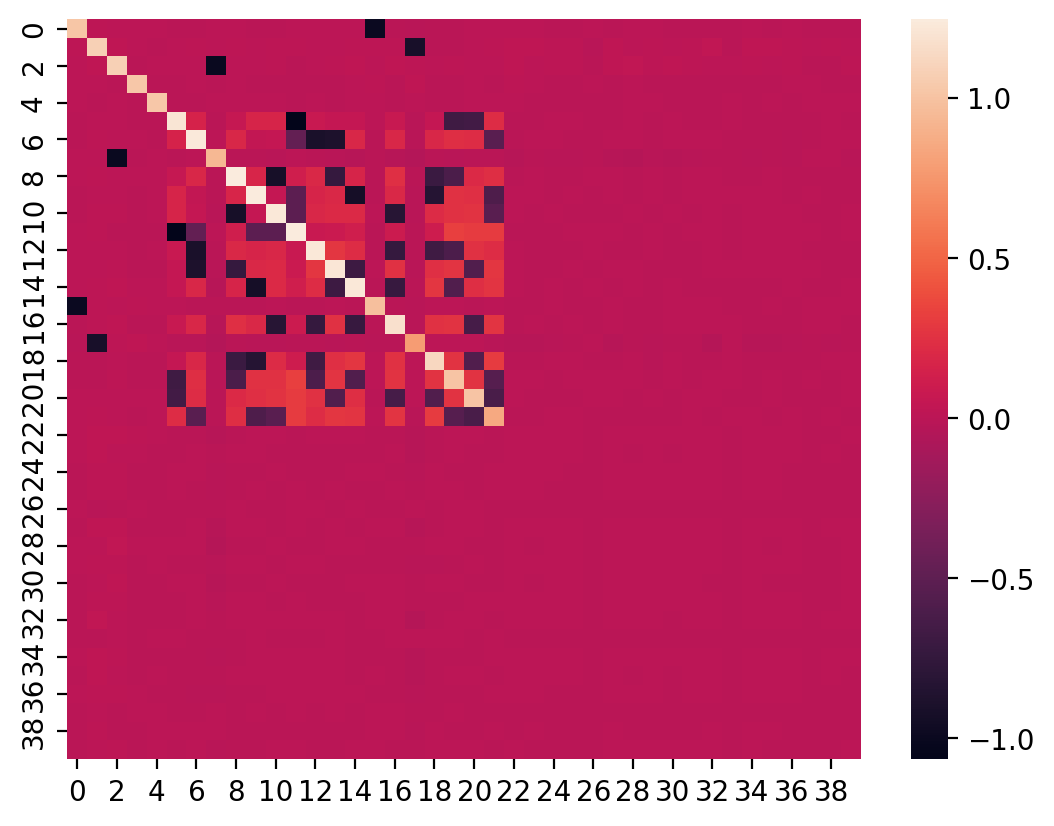

In [122]:
sns.heatmap(W@W.T)

# Feature geometry

In [13]:
config = Config(
    n_features = 200,
    n_hidden = 20,
    n_instances = 20,
)

model = Model(
    config=config,
    device=DEVICE,
    # For this experiment, use constant importance.

    # Sweep feature frequency across the instances from 1 (fully dense) to 1/20
    feature_probability = (20 ** -torch.linspace(0, 1, config.n_instances))[:, None]
)

In [14]:
optimize(model)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [71]:
fig = px.line(
    x=1/model.feature_probability[:, 0].cpu(),
    y=(model.config.n_hidden/(torch.linalg.matrix_norm(model.W.detach(), 'fro')**2)).cpu(),
    log_x=True,
    markers=True,
)
fig.update_xaxes(title="1/(1-S)")
fig.update_yaxes(title=f"m/||W||_F^2")

In [72]:
@torch.no_grad()
def compute_dimensionality(W):
  norms = torch.linalg.norm(W, 2, dim=-1) 
  W_unit = W / torch.clamp(norms[:, :, None], 1e-6, float('inf'))

  interferences = (torch.einsum('eah,ebh->eab', W_unit, W)**2).sum(-1)

  dim_fracs = (norms**2/interferences)
  return dim_fracs.cpu()

In [73]:
dim_fracs = compute_dimensionality(model.W)

In [74]:
fig = go.Figure()

density = model.feature_probability[:, 0].cpu()
W = model.W.detach()

for a,b in [(1,2), (2,3), (2,5), (2,6), (2,7)]:
    val = a/b
    fig.add_hline(val, line_color="purple", opacity=0.2, annotation=dict(text=f"{a}/{b}"))

for a,b in [(5,6), (4,5), (3,4), (3,8), (3,12), (3,20)]:
    val = a/b
    fig.add_hline(val, line_color="blue", opacity=0.2, annotation=dict(text=f"{a}/{b}", x=0.05))

for i in range(len(W)):
    fracs_ = dim_fracs[i]
    N = fracs_.shape[0]
    xs = 1/density
    if i!= len(W)-1:
        dx = xs[i+1]-xs[i]
    fig.add_trace(
        go.Scatter(
            x=1/density[i]*np.ones(N)+dx*np.random.uniform(-0.1,0.1,N),
            y=fracs_,
            marker=dict(
                color='black',
                size=1,
                opacity=0.5,
            ),
            mode='markers',
        )
    )

fig.update_xaxes(
    type='log', 
    title='1/(1-S)',
    showgrid=False,
)
fig.update_yaxes(
    showgrid=False
)
fig.update_layout(showlegend=False)

/var/folders/d9/_sfhw3kd21dgyrgz6tbt45z80000gn/T/ipykernel_92785/1338938532.py:22: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)

